# Acceleration

> Module containing helper functions and classes around acceleration

In [ ]:
#|default_exp acceleration

In [ ]:
 #| export
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
from operator import attrgetter
from functools import partial
import fastcore.all as fc
import math
import torcheval.metrics as tem
import matplotlib.pyplot as plt
import random
import numpy as np
from nntrain.learner import Subscriber

In [ ]:
 #| export
class SGD:
    def __init__(self, params, lr, wd=0.):
        self.params = list(params)
        self.lr = lr
        self.wd = wd
        self.i = 0

    def step(self):                    # this is the method that get's called by the Learner
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)       # first add regularization
                self.opt_step(p)       # then do the actual step
        self.i +=1

    def opt_step(self, p):
        p -= p.grad * self.lr          # regular step
    
    def reg_step(self, p):
        if self.wd != 0:               # only regularize when the weight decay parameter is set
            p *= 1 - self.lr*self.wd   # update the weights as described above

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [ ]:
 #| export
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

In [ ]:
 #| export
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom = sqr_mom
        self.eps = eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): 
            p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + (1-self.sqr_mom)*p.grad**2
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

In [ ]:
 #| export
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): 
            p.avg = torch.zeros_like(p.grad.data)
            p.sqr_avg = torch.zeros_like(p.grad.data)
            
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

In [ ]:
 #| export
class SchedulerS(Subscriber):
    def __init__(self, scheduler_class):
        self.scheduler_class = scheduler_class
    
    # intialize the scheduler instance after the optimizer has been intialized
    def before_fit(self, learn):
        self.scheduler = self.scheduler_class(learn.opt) 
        
    # step the scheduler after the optimizer has stepped
    def after_step(self, learn):
        self.scheduler.step()

In [ ]:
 #| export
def conv_conn(in_c, out_c, kernel_size=3, stride=2):
    return nn.Sequential(
        conv_block(in_c, out_c, kernel_size=kernel_size, stride=1, act=True, norm=True),
        conv_block(out_c, out_c, kernel_size=kernel_size, stride=stride, act=False, norm=True)
    )

In [ ]:
 #| export
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=2):
        super().__init__()
        self.in_c = in_c
        self.out_c = out_c
        self.stride = stride
        self.conv_conn = conv_conn(in_c, out_c, stride=stride)
        self.identity_conn = conv_block(in_c, out_c, kernel_size=1, stride=1, act=False, norm=False)
        self.pooling = torch.nn.AvgPool2d(2, ceil_mode=True)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        y_conv = self.conv_conn(x)
        if self.in_c == self.out_c: y_id = x
        elif self.stride == 1:
            y_id = self.identity_conn(x)
        else:
            y_id = self.pooling(self.identity_conn(x))
        return self.relu(y_conv + y_id)

In [ ]:
 #| export
def resnet():
    return nn.Sequential(                             # pixel grid input: 28x28  
        ResBlock(1 , 8, stride=1),                    # 28x28
        ResBlock(8 ,16),                              # 14x14
        ResBlock(16,32),                              # 7x7
        ResBlock(32,64),                              # 4x4
        ResBlock(64,128),                             # 2x2
        ResBlock(128,256),                            # 1x1
        nn.Flatten(),                                 # flatten to 256 features
        nn.Linear(256, 10, bias=False),               # linear layer to map to 10 output features
        nn.BatchNorm1d(10)                            # final batchnorm layer
    )

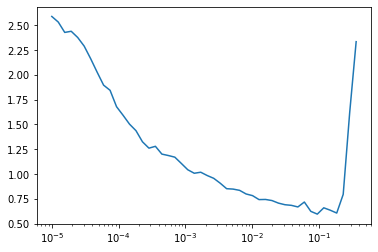

In [ ]:
set_seed(1)

model = resnet().apply(init_weights)

lrfind = LRFindS()

lrfind_subs = [norm,
               DeviceS(device),
               lrfind]

start_lr = 1e-5
l = Learner(model, dls, F.cross_entropy, torch.optim.Adam, start_lr, lrfind_subs)
l.fit(1)

lrfind.plot()

epoch,mode,loss,accuracy
0,train,0.815,0.783
0,eval,0.578,0.846
1,train,0.399,0.889
1,eval,0.372,0.885
2,train,0.282,0.914
2,eval,0.292,0.906
3,train,0.212,0.934
3,eval,0.257,0.918
4,train,0.159,0.953
4,eval,0.237,0.927


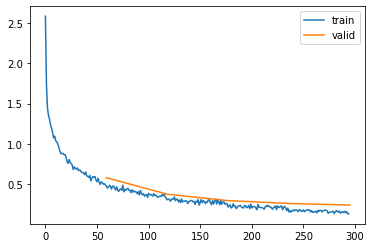

In [ ]:
set_seed(1)

model = resnet().apply(init_weights)

lr = 1e-2
sch = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=N)

subs_sch = subs + [SchedulerS(sch)]

l = Learner(model, dls, F.cross_entropy, torch.optim.Adam, lr, subs_sch)
l.fit(epochs)

Which reaches a score of almost 93% within 5 epochs!

## Parameters and MACs

Now that we are able to create fairly deep models, it's a good idea to be able to track the memory footprint and the amount of compute that is involved in doing a single forward pass. To track the memory, we can look at the amount of parameters of each layer, and for the compute we can try to estimate something equivalent to Multiply–accumulate operations (MACs). Let's create a small Subscriber that tracks thes stats by running one single batch and then cancels the fit:

In [ ]:
 #| export
class ModelMonitorS(Subscriber):
    
    def __init__(self, modules): self.modules = modules
    
    def before_fit(self, learn):
        self.hooks = [Hook(i, module, partial(self.record_stats, learn)) for i, module in enumerate(self.modules)]
        
    def record_stats(self, learn, hook, layer, inp, outp):
        if learn.model.training:
            hook.nparams = sum(submodule.numel() for submodule in layer.parameters())
            if isinstance(layer, ResBlock):
                # K × K × Cin × Hout × Wout × Cout source=https://machinethink.net/blog/how-fast-is-my-model/
                mac_conv1 = 9 * layer.in_c * inp[0].shape[2] * inp[0].shape[3] * layer.out_c
                mac_conv2 = 9 * layer.out_c * outp.shape[2] * outp.shape[3] * layer.out_c    
                hook.mac = (mac_conv1 + mac_conv2) / 1e6
                if layer.stride != 1:
                    # Add identity conv
                    hook.mac += (layer.in_c * outp.shape[2] * outp.shape[3] * layer.out_c / 1e6)
            else:
                hook.mac = hook.nparams / 1e6
            hook.batch_size = inp[0].shape[0]
            hook.in_shape = list(inp[0].shape[1:])
            hook.out_shape = list(outp.shape[1:])
            
    def after_batch(self, learn):
        for h in self.hooks: h.remove()
        raise CancelFitException                   # Only run this for a single batch, then cancel
        
    def __repr__(self):
        out = f'{"layer":<20} : {"input":<20} : {"output":<20} : {"# params":>10} : {"# MACs":>10}\n'
        total_params = 0
        total_mac = 0
        for h in self.hooks:
            out += f'{h.layer_name:<20} : {str(h.in_shape):<20} : {str(h.out_shape):<20} : {h.nparams:>10d} : {h.mac: 10.1f}\n'
            total_params += h.nparams
            total_mac += h.mac
        return f'{"Total parameters:":<20}{total_params:>10d} \n{"Total MACs:":<20}{total_mac:10.1f} \n\n' + out

In [ ]:
model = resnet().apply(init_weights)

modules = [module for module in model.modules() if isinstance(module, (ResBlock, nn.Linear, torch.nn.BatchNorm1d))]
monitor = ModelMonitorS(modules)

l = Learner(model, dls, F.cross_entropy, torch.optim.Adam, lr, [monitor])
l.fit(1)

monitor

Total parameters:      1227900 
Total MACs:                8.4 

layer                : input                : output               :   # params :     # MACs
0_ResBlock           : [1, 28, 28]          : [8, 28, 28]          :        696 :        0.5
1_ResBlock           : [8, 28, 28]          : [16, 14, 14]         :       3664 :        1.4
2_ResBlock           : [16, 14, 14]         : [32, 7, 7]           :      14496 :        1.4
3_ResBlock           : [32, 7, 7]           : [64, 4, 4]           :      57664 :        1.5
4_ResBlock           : [64, 4, 4]           : [128, 2, 2]          :     230016 :        1.8
5_ResBlock           : [128, 2, 2]          : [256, 1, 1]          :     918784 :        1.8
6_Linear             : [256]                : [10]                 :       2560 :        0.0
7_BatchNorm1d        : [10]                 : [10]                 :         20 :        0.0

From which we see how data flows through the model, where most parameters are and where most compute is being spend. Although the MACs computation isn't perfectly valid, it gives a good indication. It especially shows:

- most parameters are in later layers, those are the layers that cost most memory. In fact the final ResBlock uses more memory as all earlier ResBlocks combined!
- this is also where most compute is being used, although the differences between earlier layers is much less pronounced then for the memory footprint, the reason for this is that the pixel grid is reduced a lot in those later layers

## Augmentation

We have finally come to the point of data augmentation. Once you have a good model, you would ideally train for much longer times. When doing so, the problem that arises is that of overfitting. Which we described before as the tendency of the model to start to memorize our training data and no longer generalize well to the validation set. 

To overcome this, data augmentation is used to increase the variety in the training data. For example we can rotate the images, or (horizontally or vertically) flip the image. For such augmentations the label stays the same, since a rotated image of a shoe is still a shoe, but there exist also augmentations that for example mix images, and thus also the labels are altereed. There are great libraries out there such as [Albumentations](https://demo.albumentations.ai/) with a huge variety of transformations that can be applied to images, so we won't be going into the full details. But let's at least figure out how we can build this into our framework.

In [ ]:
 #| export
class AugmentS(Subscriber):
    def __init__(self, transform):
        self.transform = transform
        
    def before_batch(self, learn):
        if learn.model.training:                    # augmentations are only applied to the training data
            learn.batch[0] = self.transform(learn.batch[0])

In [ ]:
from torchvision import transforms

augs = nn.Sequential(transforms.RandomHorizontalFlip(), 
                     transforms.RandomCrop(size=28, padding=1))

epoch,mode,loss,accuracy
0,train,1.052,0.694
0,eval,0.757,0.778
1,train,0.641,0.837
1,eval,0.591,0.841
2,train,0.492,0.869
2,eval,0.587,0.838
3,train,0.401,0.882
3,eval,0.407,0.871
4,train,0.340,0.893
4,eval,0.378,0.873


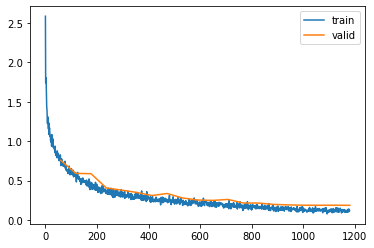

In [ ]:
set_seed(1)

model = resnet().apply(init_weights)

epochs=20
lr = 1e-2
sch = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=N)

subs_sch = subs + [SchedulerS(sch), AugmentS(augs)]

l = Learner(model, dls, F.cross_entropy, torch.optim.Adam, lr, subs_sch)
l.fit(epochs)

## Final Remarks

And that's it. We have created a model that is performing with close to 94% accuracy on the fashion-mnist dataset, according to [papers with code](https://paperswithcode.com/sota/image-classification-on-fashion-mnist), that puts us in the top 10 of papers that are written about this dataset, and we did so with just 20 epochs of training and limitted data augmentation. 

In the previous posts in this series, we have build up a small library [`nntrain`](https://lucasvw.github.io/nntrain/) in which we have build more or less everything from scratch, from data loading, training loop, activation tracking, initialization, convolutions, optimizers, schedulers and finally ResNets and data augmentation. We understand in detail how it all works, and it's fairly straight forward to extend the framework to different kind of Machine Learning challenges. 

I can't thank Jeremy Howard and the people from FastAI enough for all the wonderful things they are doing for the machine learning community, it truly is spectacular and inspiring 🤗. To close off, I would like to share a small snippet from the last "base" lecture in which Jeremy Howard speaks some words about this himself and reinforces the idea that nothing in machine learning is magic, that everything can be understood with common sense and be build from scratch with enough perseverance and tenacity.

{{< video https://www.youtube.com/embed/nlVOG2Nzc3k?si=QAzDjVCkOO5CM5GD?&start=7260&end=7335 >}}